In [1]:
import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
%autosave 180

from IPython.core.display import display, HTML


Autosaving every 180 seconds


In [2]:
import nidaqmx
from nidaqmx.constants import AcquisitionType
import matplotlib.pyplot as plt

location = 'animals'
sample_time = 60*10  # units = seconds
s_freq = 250000
print (s_freq)
print ("Location: ", location)
num_samples = sample_time*s_freq
dt = 1/s_freq

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    
    task.timing.cfg_samp_clk_timing(s_freq,
                                   sample_mode = AcquisitionType.CONTINUOUS)
    
    
    data1 = task.read(number_of_samples_per_channel=num_samples, timeout = nidaqmx.constants.WAIT_INFINITELY)

data1=np.array(data1)
print (data1.shape)
np.save('C:\data\location_'+location+"_"+str(sample_time)+'sec.npy', data1)

250000
Location:  animals
(4, 150000000)


In [8]:
data1=np.array(data1)
print (data1.shape)
np.save('C:\data\location_'+str(location), data1)

(4, 1250000)


In [3]:
print (len(data1), len(data1[0]))
data1 = np.array(data1)

2 655360


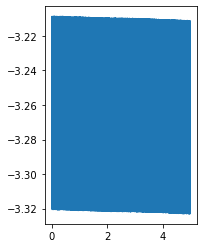

In [7]:
# plot data 
t = np.arange(len(data1[0]))/float(s_freq)
ax=plt.subplot(1,2,1)
plt.plot(t, data1[1])

# ax=plt.subplot(1,2,2)

# P, extent = Specgram(data = data1[1], sampfreq = s_freq, 
#                     p0=-300, f0=0.1, f1=s_freq, 
#                     width=0.01, tres = 0.005)
# plt.imshow(P,extent=extent, aspect='auto')     
plt.show()


In [25]:
data = np.load('C:\data\location_8_15sec.npy')
print (data.shape)

(4, 3750000)


In [29]:
%matplotlib tk
t = np.arange(data[0].shape[0])/250000.
fig=plt.figure(figsize=(30,30))
start = int(2.23*250000)
end = int(2.235*250000)
for k in range(4):
    plt.plot(t[start:end],data[k,start:end]+k*0.1,alpha=.6)
plt.savefig('C:\data\plot.png', dpi=100)
#plt.show()
plt.close()
    

In [5]:
#Function that computes power spetrum density (PSD) and specgrams for ephys data. 
# 

import struct
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

def Specgram(data, sampfreq, p0=-40, f0 = 0.1, f1 = 110,
             width = 2, tres=0.5):

    t0=None
    t1=None
    #f0=0.1
    #f1=110
    #p0=-60
    p1=None
    #chanis=-1
    #width=2
    #tres=.5
    #cm=None
    #colorbar=False
    #title=True
    #figsize=(20, 6.5)
    
    P0, P1 = None, None

    #sampfreq=SampleFrequency #1KHZ LFP SAMPLE RATE for Nick's data; Otherwise full sample rates;

    #NFFT = intround(width * sampfreq)
    #NOVERLAP = intround(NFFT - tres * SAMPFREQ)

    length = len(data)

    ts = np.arange(0,len(data),1.0)/sampfreq

    if t0 == None:
        t0, t1 = ts[0], ts[-1] # full duration
    #if t1 == None:
    #    t1 = t0 + 10 # 10 sec window
    if width == None:
        width = uns['LFPWIDTH'] # sec
    if tres == None:
        tres = uns['LFPTRES'] # sec
    assert tres <= width

    NFFT = intround(width * sampfreq)
    noverlap = intround(NFFT - tres * sampfreq)

    t0i, t1i = ts.searchsorted((t0, t1))

    #data = filter.notch(data)[0] # remove 60 Hz mains noise

    print ("Computing regular fft specgram")
    P, freqs, t = mpl.mlab.specgram(data/1e3, NFFT=NFFT, Fs=sampfreq, noverlap=noverlap)
    
    # convert t to time from start of acquisition:
    t += t0
    # keep only freqs between f0 and f1:
    if f0 == None:
        f0 = freqs[0]
    if f1 == None:
        f1 = freqs[-1]
    lo, hi = freqs.searchsorted([f0, f1])
    P, freqs = P[lo:hi], freqs[lo:hi]
    #print P
    
    # check for and replace zero power values (ostensibly due to gaps in recording)
    # before attempting to convert to dB:
    zis = np.where(P == 0.0) # row and column indices where P has zero power
    if len(zis[0]) > 0: # at least one hit
        P[zis] = np.finfo(np.float64).max # temporarily replace zeros with max float  #CAT: This can probably be unhacked using nanmax or masked arrays
        minnzval = P.min() # get minimum nonzero value
        P[zis] = minnzval # replace with min nonzero values
    P = 10. * np.log10(P) # convert power to dB wrt 1 mV^2?

    # for better visualization, clip power values to within (p0, p1) dB
    if p0 != None:
        P[P < p0] = p0
    if p1 != None:
        P[P > p1] = p1

    extent = ts[0], ts[-1], freqs[0], freqs[-1]

    return P[::-1], extent

  
def intround( n):
    """Round to the nearest integer, return an integer. Works on arrays.
    Saves on parentheses, nothing more"""
    if iterable(n): # it's a sequence, return as an int64 array
        return np.int64(np.round(n))
    else: # it's a scalar, return as normal Python int
        return int(round(n))
            
def iterable(x):
    """Check if the input is iterable, stolen from numpy.iterable()"""
    try:
        iter(x)
        return True
    except:
        return False

In [55]:
import nidaqmx
import sys

import matplotlib.pyplot as plt
import PySpin
import simpleaudio as sa
from nidaqmx.constants import AcquisitionType, Edge

s_freq = 250000
print (s_freq)
#print ("Location: ", root_dir)
duration = 10
num_samples = duration*s_freq
dt = 1/s_freq



with nidaqmx.Task() as task:
    ai_channel_1 = task.ai_channels.add_ai_voltage_chan("Dev1/ai0",
                                                     max_val=2.5,
                                                     min_val=-2.5)

    ai_channel_2 = task.ai_channels.add_ai_voltage_chan("Dev1/ai1",
                                                    min_val=-2.5,
                                                    max_val=2.5)
    #task.ai_channels.all.ai_max = 2.5
    #task.ai_channels.all.ai_min = -2.5
    nidaqmx._task_modules.channels.ai_channel.AIChannel.ai_max = 2.5
    nidaqmx._task_modules.channels.ai_channel.AIChannel.ai_min = -2.5

    print (ai_channel_1.ai_max, ai_channel_1.ai_min)
            
            
    #task.ao_channels.add_ao_voltage_chan("Dev1/ai0")
    print (task.ai_channels.all.ai_max, task.ai_channels.all.ai_min)

    #data1 = task.read(number_of_samples_per_channel=num_samples, timeout = nidaqmx.constants.WAIT_INFINITELY)

    #data1=np.array(data1)
    #print (data1.shape)
    #np.save(fname_out, data1)

250000
2.5 -2.5
2.5 -2.5


In [71]:
import playsound
wav_fname =r'C:\data\data\waves\audiocheck.net_sin_7000Hz_0dBFS_5s.wav'
playsound.playsound(wav_fname)


In [140]:
data_48db = np.load(r'D:\july_15_outside_7000Hz\audio\2020-07-15_11_45_38.077081_audio_5V_TDT_48db.npy')
data_24db = np.load(r'D:\july_15_outside_7000Hz\audio\2020-07-15_11_31_50.170885_audio_5V_TDT_24db.npy')
data_clap = np.load(r'D:\july_15_outside_7000Hz\audio\2020-07-15_11_52_40.539353_audio.npy')
data_7Khz = np.load(r'D:\july_15_outside_7000Hz\audio\2020-07-15_12_15_53.350279_audio.npy')
data_usv = np.load(r'D:\july_15_outside_USV_6\audio\2020-07-15_12_11_20.592380_audio_noSound_cage.npy')
#print (data.shape)

In [141]:
#ax=plt.subplot(1,2,2)
from Specgram.Specgram import Specgram
s_freq = 250000
P, extent = Specgram(data = data_7Khz[0], sampfreq = s_freq, 
                    p0=-300, f0=0.1, f1=s_freq, 
                    width=0.01, tres = 0.005)
plt.imshow(P,extent=extent, aspect='auto')   
plt.show()

Computing regular fft specgram


In [7]:
data = np.load(r'D:\july_15_epoch_tests\audio\2020-07-15_15_34_25.614427_audio.npy')

In [8]:
#plt.plot(data_24db[0]*10.)
#plt.plot(data_48db[0]+0.5)
for k in range(5):
    ax=plt.subplot(2,3,k+1)
    plt.plot(data[k])
plt.show()

In [100]:
ax=plt.subplot(1,2,1)
plt.hist(data_24db[0],bins=np.arange(-0.1,+0.1,0.001))
ax=plt.subplot(1,2,2)
plt.hist(data_48db[0],bins=np.arange(-0.1,+0.1,0.001)*10)
plt.show()
